# Gaussian Process

## Introduction

[Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) has been used in supervised, unsupervised, and even reinforcement learning problems. It has a beautiful mathematical theory (for an overview of the subject, see [1]). In particular, its distribution can be considered as a distribution over functions. Many machine learning models give specific predictions, not how uncertainty the predictions are. Gaussian process particularly helps us solve such problems. Currently, there is a simple implementation of Gaussian process regression model at `pyro.contrib.gp` module. We will try to use it in this tutorial. The model is defined as
$$f \sim \mathcal{GP}\left(0, \mathbf{K}_f(x, x')\right)$$
and
$$y = f + \epsilon,\quad \epsilon \sim \mathcal{N}\left(0, \beta^{-1}\mathbf{I}\right).$$

We will use [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF kernel) as the kernel of Gaussian process:
$$ k(x,x') = \sigma^2 \exp\left(-\frac{\|x-x'\|^2}{2l^2}\right),$$
where $\sigma^2$ is variance and $l$ is lengthscale of the RBF kernel.

## Prepare

First, we need import necessary modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch

import pyro
from pyro.contrib.gp.kernels import RBF
from pyro.contrib.gp.models import GPRegression, SparseGPRegression, SparseVariationalGP
from pyro.contrib.gp.likelihoods import Gaussian
import pyro.distributions as dist
from pyro.infer import SVI
from pyro.optim import Adam
pyro.set_rng_seed(0)

import os
smoke_test = ('CI' in os.environ)
pyro.enable_validation(False) # MVN precision conversion issue - see: https://github.com/uber/pyro/issues/953

It is better to make visualizations for Gaussian process' implementation. So we create a convenient function to plot.

In [2]:
def plot(model=None, n_sample=0, variational=False):
    plt.figure(figsize=(12, 6))
    plt.plot(X.numpy(), y.numpy(), 'kx')  # plot data
    if model is not None:
        Xnew = torch.linspace(-0.5, 5.5, 100)  # new input
        with torch.no_grad():
            # mean and variance of output's Gaussian distribution
            if variational:
                mean, cov = model(Xnew, full_cov=True)
                noise = model.likelihood.get_param("variance")
                cov = cov + noise.expand(mean.size(0)).diag()
            else:
                mean, cov = model(Xnew, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard derivation at each input
        plt.plot(Xnew.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xnew.numpy(), mean.numpy() - 2*sd.numpy(), mean.numpy() + 2*sd.numpy(),
                         color='C0', alpha=0.3)  # fill the interval (mean-2.sd, mean+2.sd)
        if n_sample > 0:  # plot the samples
            n_sample = n_sample if not smoke_test else 1
            samples = dist.MultivariateNormal(mean, covariance_matrix=cov) \
                          .sample(sample_shape=torch.Size([n_sample]))
            plt.plot(Xnew.numpy(), samples.numpy().T, 'C0', lw=2, alpha=0.4)
    plt.xlim(-0.5, 5.5)
    plt.ylim(-3, 3)

## Data

The data consists of $20$ points sampled from
$$ y = 0.5\sin(3x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5).$$

In [3]:
# source: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
N = 20
X = dist.Uniform(torch.zeros(N), torch.ones(N)*5).sample()
y = 0.5 * torch.sin(3*X) + dist.Normal(torch.zeros(N), torch.ones(N)*0.5).sample()

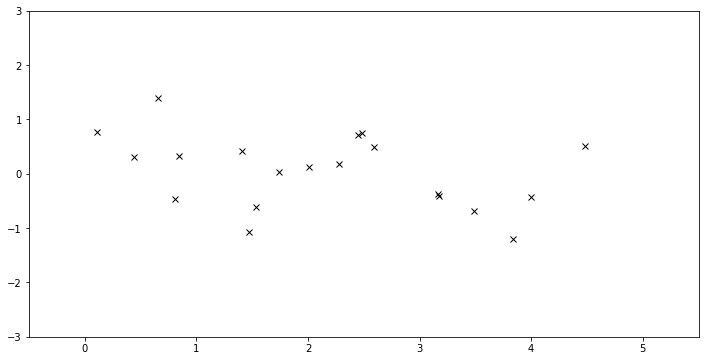

In [4]:
plot()

## Define model

In [5]:
kernel = RBF(input_dim=1, variance=torch.tensor(10.), lengthscale=torch.tensor(10.))
gpr = GPRegression(X, y, kernel, noise=torch.tensor(1.))

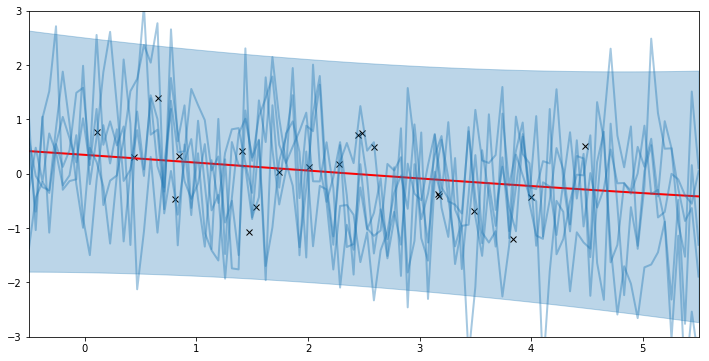

In [6]:
plot(gpr, n_sample=5)

## Inference

In [7]:
optim = Adam({"lr": 0.001})
svi = SVI(gpr.model, gpr.guide, optim, loss="ELBO")
losses = []
num_steps = 1000 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())

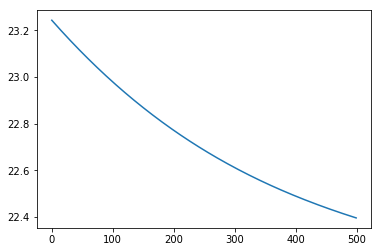

In [8]:
# look at the loss
plt.plot(losses[-500:])

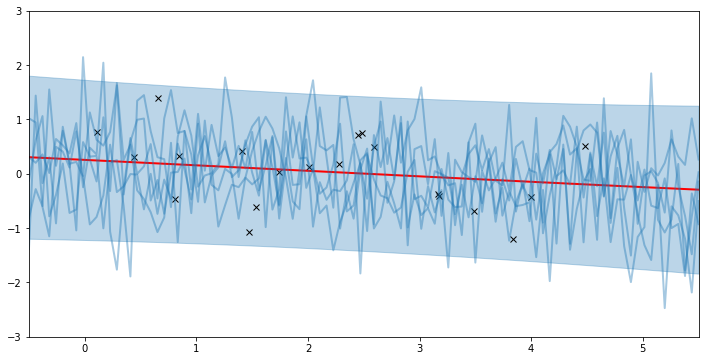

In [9]:
# see the inference result; because we initiated the `lengthscale=10`,
# which is so large comparing to the data range (0, 5), it is hard to make the model learn
plot(gpr, n_sample=5)

In [10]:
# observe the parameters
for param, value in pyro.get_param_store().named_parameters():
    print(param, value)

RBF$$$lengthscale_unconstrained 
 2.7259
[torch.FloatTensor of size ()]

noise_unconstrained 
-0.7328
[torch.FloatTensor of size ()]

RBF$$$variance_unconstrained 
 1.4176
[torch.FloatTensor of size ()]



In some cases, the inference will make `variance` or `lengthscale` become negative numbers. To solve that problem, we have to force these parameters to be positive. Thankfully, from version `0.4`, Pytorch supports a very generic way to put constraints to parameters (see [docs](http://pytorch.org/docs/master/distributions.html#module-torch.distributions.constraints)). Most Gaussian Process parameters in Pyro use constraints by default. To see the constrained value, we will use `get_param(...)` method.

In [11]:
gpr.kernel.get_param("variance")


 4.1270
[torch.FloatTensor of size ()]

In [12]:
gpr.kernel.get_param("lengthscale")


 15.2700
[torch.FloatTensor of size ()]

In [13]:
gpr.get_param("noise")


 0.4805
[torch.FloatTensor of size ()]

With RBF kernel, the larger lengthscale, we get the smoother samples (this can be deduced from the formula of $K$: the larger lengthscale, the more likeliness that $K$ will approach $1$, which in turn reflects the values of two points $x$ and $x'$ are similar). Variance parameter controls the derivation from the mean (besides the noise). Comparing the initial plot with the last plot, we can see that the second plot is less variant.

### Fit the model using MAP

We need to define the priors for parameters. Beside it is more reliable approach, it will also help dealing with the constraints of parameters.

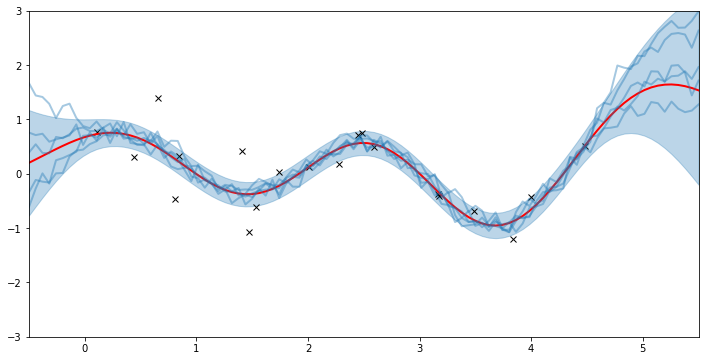

In [14]:
gpr.kernel.set_prior("lengthscale", dist.LogNormal(torch.zeros(1), torch.ones(1)))
gpr.kernel.set_prior("variance", dist.LogNormal(torch.zeros(1), torch.ones(1)))
# we fix the noise to 0.01
gpr.fix_param("noise", torch.ones(1) * 0.01)
# we need to reset param store
pyro.clear_param_store()
optim = Adam({"lr": 0.001})
svi = SVI(gpr.model, gpr.guide, optim, loss="ELBO")
losses = []
num_steps = 1000 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())
plot(gpr, n_sample=5)

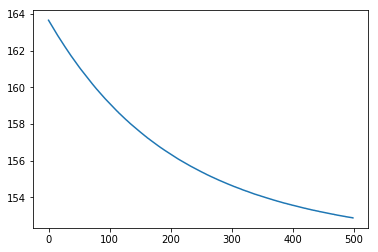

In [15]:
plt.plot(losses[-500:]);

We can see that the model might still learn. We will run more iterations. However, it might cause "overfitting".

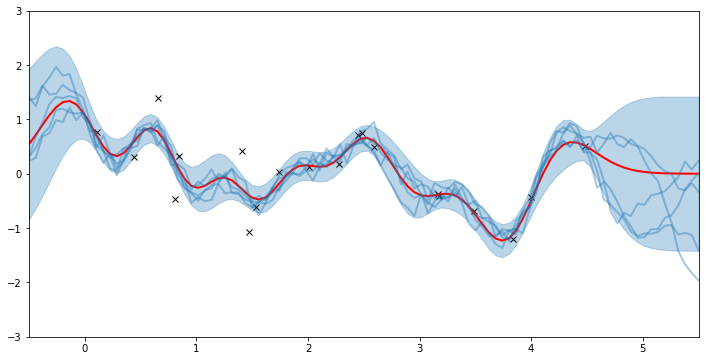

In [16]:
num_steps = 4000 if not smoke_test else 2
for i in range(num_steps):
    svi.step()
plot(gpr, n_sample=5)

Now, look at the parameters, we can see that the names of parameters have been changed. The reason is that: when we put priors to parameters of our kernel, they become random variables (not `torch.nn.Parameter` anymore). Inference will learn the parameters with trailing `_MAP` at the end.

In [17]:
for param, value in pyro.get_param_store().named_parameters():
    print(param, value)

RBF$$$variance_MAP 
 0.4927
[torch.FloatTensor of size (1,)]

RBF$$$lengthscale_MAP 
 0.3281
[torch.FloatTensor of size (1,)]



## Sparse Approximation

In case the number of data is large, using the Gaussian Process Regression model is computationally ineffective (see Section 2.2 of [1]). So we will use `SparseGPRegression` model, which helps reduce time consuming significantly.

First, we generate more data.

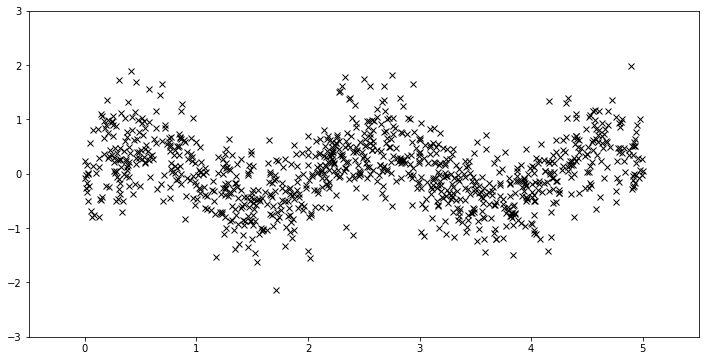

In [18]:
N = 1000
X = dist.Uniform(torch.zeros(N), torch.ones(N)*5).sample()
y = 0.5 * torch.sin(3*X) + dist.Normal(torch.zeros(N), torch.ones(N)*0.5).sample()
plot()

Using the sparse version is quite similar to the original version. We just need to add an extra parameter $Xu$, which plays the role of inducing points.

In [19]:
# initiate the position of inducing inputs
Xu = torch.tensor([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

# initiate the kernel and model
kernel = RBF(input_dim=1)
sgpr = SparseGPRegression(X, y, kernel, Xu=Xu)
sgpr.fix_param("noise", torch.ones(1) * 0.01)

# the learning steps are similar to learning GPRegression
pyro.clear_param_store()
optim = Adam({"lr": 0.001})
svi = SVI(sgpr.model, sgpr.guide, optim, loss="ELBO")
losses = []
num_steps = 1000 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())

RBF$$$lengthscale_unconstrained 
1.00000e-02 *
 -6.4616
[torch.FloatTensor of size (1,)]

Xu 
 0.1906
 0.7538
 1.4608
 2.1544
 2.7996
 3.4919
 4.0894
 4.5825
 4.9701
[torch.FloatTensor of size (9,)]

RBF$$$variance_unconstrained 
 0.3038
[torch.FloatTensor of size (1,)]



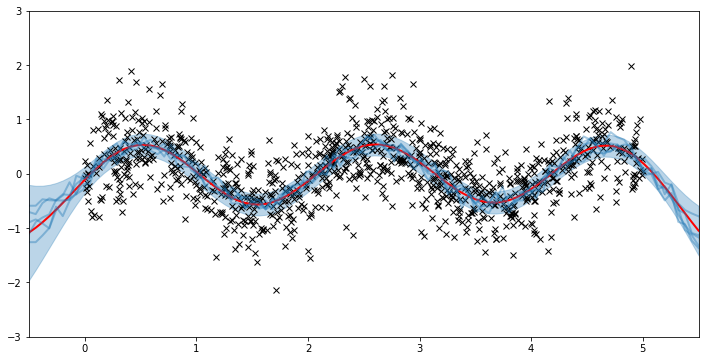

In [20]:
for param, value in pyro.get_param_store().named_parameters():
    print(param, value)
plot(sgpr, n_sample=5)

We can see that the model learns this data pretty well. There are three versions, which are currently implemented in Pyro, for sparse approximation: "DTC" (Deterministic Training
Conditional), "FITC" (Partially Independent Training Conditional), and "VFE" (Variational Free Energy). By default, `SparseGPRegression` will use "VFE" as the main inference method. We can use other methods by changing the `approx` parameter.

## Sparse Variational Gaussian Process

The noise in regression model plays the role of Gaussian likelihood. To deal with general likelihood (for example, we use Bernoulli likelihood for classification problems), we will use variational inference. In this section, we will give an example on how to use `SparseVariationGP` module.

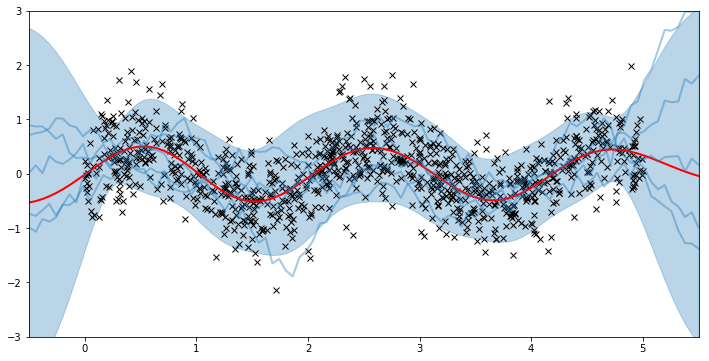

In [21]:
# initiate the position of inducing inputs
# here, we just use 9 inducing points
# we recommend to increase the number of inducing points for better inference
Xu = torch.tensor([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

# initiate the kernel, likelihood, and model
kernel = RBF(input_dim=1)
likelihood = Gaussian()
svgp = SparseVariationalGP(X, y, kernel, Xu=Xu, likelihood=likelihood, jitter=1e-5)
# fix the noise to 0.01
svgp.likelihood.fix_param("variance", torch.ones(1) * 0.01)

pyro.clear_param_store()
optim = Adam({"lr": 0.01})
svi = SVI(svgp.model, svgp.guide, optim, loss="ELBO")
losses = []
num_steps = 1000 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())
    
plot(svgp, n_sample=5, variational=True)

We can see that the model predicts well the target $y = 0.5\sin(3x)$ despite of noisy data.

## Some remarks

+ In Gaussian Process, we usually have to solve the equation $Kx = y$, where $K$ is a positive covariance matrix. An efficiency and numerically-stable method to obtain the solution is to use [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). First, we decompose $K = LL^T$, where $L$ is a lower triangular matrix. Then, we solve in turn $Lz = y$ and $L^Tx = z$.

+ The Cholesky decomposition `torch.potrf` usually throws the `RuntimeError`: "Lapack Error in potrf : the leading minor of order {} is not positive definite". The error tells itself: while decomposing, some eigenvalues of covariance matrix are approximately $0$ (and turn out to be negative). To deal with such error, one way is to cast our model's parameters to `DoubleTensor` (by calling `.double` from our model). Another way is to introduce the notion `jitter`. We will add a small positive term (named `jitter`) into the diagonal part of $K$ before decomposing the covariance matrix. Due to the `noise` component, all eigenvalues will be positive. Adding `jitter` is necessary when using Gaussian Process in variational framework. By default, in each model, we set `jitter=1e-6`. When getting that error, we recommend increasing `jitter` to a higher value.

## Reference

[1] `Deep Gaussian processes and variational propagation of uncertainty`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Andreas Damianou

[2] `A unifying framework for sparse Gaussian process approximation using power expectation propagation`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Thang D. Bui, Josiah Yan, and Richard E. Turner

[3] `Scalable variational Gaussian process classification`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
James Hensman, Alexander G. de G. Matthews, and Zoubin Ghahramani

[4] `Gaussian Processes for Machine Learning`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Carl E. Rasmussen, and Christopher K. I. Williams

[5] `A Unifying View of Sparse Approximate Gaussian Process Regression`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Joaquin Quinonero-Candela, and Carl E. Rasmussen